In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline 

In [13]:
from itertools import cycle

In [8]:
from sklearn import metrics
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, LabelBinarizer

In [4]:
from sklearn.neural_network import MLPClassifier

In [5]:
# load training data 

df_train = pd.read_csv('/content/drive/MyDrive/Major Project/notebooks/me/data/train.csv')
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.008697,0.0,0.000000,0.0,0.0,0.042426,0.003253,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.007640,0.0,1.154701,0.0,0.0,0.055076,0.044573,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.028117,0.0,1.000000,0.0,0.0,0.076322,0.037977,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.025953,0.0,1.095445,0.0,0.0,0.073621,0.033498,187,0,0


In [6]:
# load test data 

df_test = pd.read_csv('/content/drive/MyDrive/Major Project/notebooks/me/data/test.csv')
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,...,0.021174,0.0,0.707107,0.0,0.0,0.124016,0.025037,112,0,0
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,...,0.011429,0.0,1.095445,0.0,0.0,0.069785,0.027820,98,0,0
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,...,0.030924,0.0,0.836660,0.0,0.0,0.143631,0.018966,69,0,0
3,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,...,0.021249,0.0,1.341641,0.0,0.0,0.126372,0.021106,82,0,0
4,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,...,0.009627,0.0,0.547723,0.0,0.0,0.091924,0.101100,91,0,0


Create features sets required to subset the original dataframes into original features and original + extracted features

Create training and test data labels series, and convert them to binary format as required by multiclass classification algorithms.

In [9]:
# original features
features_orig = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

# original + extracted fetures
features_extr = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'av1', 'av2', 'av3', 'av4', 'av5', 'av6', 'av7', 'av8', 'av9', 'av10', 'av11', 'av12', 'av13', 'av14', 'av15', 'av16', 'av17', 'av18', 'av19', 'av20', 'av21', 'sd1', 'sd2', 'sd3', 'sd4', 'sd5', 'sd6', 'sd7', 'sd8', 'sd9', 'sd10', 'sd11', 'sd12', 'sd13', 'sd14', 'sd15', 'sd16', 'sd17', 'sd18', 'sd19', 'sd20', 'sd21']

y_train = df_train['label_mcc']
y_test = df_test['label_mcc']

lb = LabelBinarizer()

y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

Helper function to get the best parameter for model using gridsearchCV

In [10]:
def multiclass_classify(model, clf, features, params=None, score=None, scale=False, OvR=True, prob='P'):
       
    """Perfor Grid Search hyper parameter tuning on a classifier.
    
    Args:
        model (str): The model name identifier
        clf (clssifier object): The classifier to be tuned
        features (list): The set of input features names
        params (dict): Grid Search parameters
        score (str): Grid Search score
        OvR (bool): True if the classifier inherently support multiclass One-Vs-Rest
        prob (str): For getting classification scores: 'P' for predict_proba, 'D' for decision_function
        
    Returns:
        Tuned Clssifier object
        array: prediction values
        array: prediction scores
    
    
    """
    
    
    X_train = df_train[features]

    X_test = df_test[features] 
    
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    grid_search = model_selection.GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    if prob == 'P':   
        y_score = grid_search.predict_proba(X_test)
        if OvR:    
            y_score = [y_score[i][:,[1]] for i in range(len(y_score))]
            y_score = np.concatenate(y_score, axis=1)
    elif prob == 'D':
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred
        
    
    return grid_search.best_estimator_, y_pred, y_score

For evaluation and plotting graph

In [15]:
def multiclass_metrics(model, y_test, y_pred, y_score, print_out=True, plot_out=True):
    
    """Calculate main multiclass classifcation metrics, plot AUC ROC and Precision-Recall curves.
    
    Args:
        model (str): The model name identifier
        y_test (series): Contains the test label values
        y_pred (series): Contains the predicted values
        y_score (series): Contains the predicted scores
        print_out (bool): Print the classification metrics and thresholds values
        plot_out (bool): Plot AUC ROC, Precision-Recall, and Threshold curves
        
    Returns:
        dataframe: The combined metrics in single dataframe
        dict: ROC thresholds
        dict: Precision-Recall thresholds
        Plot: AUC ROC
        plot: Precision-Recall
  
    
    """
    multiclass_metrics = {
                            'Accuracy' : metrics.accuracy_score(y_test, y_pred),
                            'macro F1' : metrics.f1_score(y_test, y_pred, average='macro'),
                            'micro F1' : metrics.f1_score(y_test, y_pred, average='micro'),
                            'macro Precision' : metrics.precision_score(y_test, y_pred,  average='macro'),
                            'micro Precision' : metrics.precision_score(y_test, y_pred,  average='micro'),
                            'macro Recall' : metrics.recall_score(y_test, y_pred,  average='macro'),
                            'micro Recall' : metrics.recall_score(y_test, y_pred,  average='micro'),
                            'macro ROC AUC' : metrics.roc_auc_score(y_test, y_score, average='macro'),
                            'micro ROC AUC' : metrics.roc_auc_score(y_test, y_score, average='micro')
                        }
    
    df_metrics = pd.DataFrame.from_dict(multiclass_metrics, orient='index')
    df_metrics.columns = [model]

   
    n_classes = y_train.shape[1]
    
    fpr = dict()
    tpr = dict()
    thresh_roc = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        #fpr[i], tpr[i], thresh_roc[i] = metrics.roc_curve(y_test[:, i], y_score[i][:,0])
        fpr[i], tpr[i], thresh_roc[i] = metrics.roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
    fpr["micro"], tpr["micro"], thresh_roc["micro"] = metrics.roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    

    roc_thresh = {
                    'Threshold' : thresh_roc,
                    'TPR' : tpr,
                    'FPR' : fpr,
                    'AUC' : roc_auc
                 }
    
    df_roc_thresh = pd.DataFrame.from_dict(roc_thresh)
    df_roc_thresh['Model'] = model
    df_roc_thresh['Class'] = df_roc_thresh.index
    
    
    
    precision = dict()
    recall = dict()
    thresh_prc = dict()
    average_precision = dict()
    
    for i in range(n_classes):
        #precision[i], recall[i], thresh_prc[i] = metrics.precision_recall_curve(y_test[:, i], y_score[i][:,0])
        precision[i], recall[i], thresh_prc[i] = metrics.precision_recall_curve(y_test[:, i], y_score[:, i])
        average_precision[i] = metrics.average_precision_score(y_test[:, i], y_score[:, i])

    precision["micro"], recall["micro"], thresh_prc["micro"] = metrics.precision_recall_curve(y_test.ravel(), y_score.ravel())
    average_precision["micro"] = metrics.average_precision_score(y_test, y_score, average="micro")
    
    prc_thresh = {
                    'Threshold' : thresh_prc,
                    'Precision' : precision,
                    'Recall' : recall,
                    'Avg Precision' : average_precision
                 }

    df_prc_thresh = pd.DataFrame.from_dict(prc_thresh)
    df_prc_thresh['Model'] = model
    df_prc_thresh['Class'] = df_prc_thresh.index    
    
    y_test_orig = lb.inverse_transform(y_test)
    y_pred_orig = lb.inverse_transform(y_pred)
    
    if print_out:
        print('-----------------------------------------------------------')
        print(model, '\n')
        print('Confusion Matrix:')
        print(metrics.confusion_matrix(y_test_orig, y_pred_orig))
        print('\nClassification Report:')
        print(metrics.classification_report(y_test_orig, y_pred_orig))
        print('\nMetrics:')
        print(df_metrics)

    if plot_out:
        
        colors = cycle(['red', 'green', 'blue'])
        
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False )
        fig.set_size_inches(12,6)
        
        for i, color in zip(range(n_classes), colors):
            ax1.plot(fpr[i], tpr[i], color=color, lw=1, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
        
        ax1.plot(fpr["micro"], tpr["micro"], color='deeppink', label='micro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["micro"]), linestyle=':', linewidth=4)
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax1.set_xlim([-0.05, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend(loc="lower right", fontsize='small')
        
        
        for i, color in zip(range(n_classes), colors):
            ax2.plot(recall[i], precision[i], color=color, lw=1, label='Precision-recall curve of class {0} (area = {1:0.2f})'.format(i, average_precision[i]))
            
        ax2.plot(recall["micro"], precision["micro"], color='deeppink', lw=4, linestyle=':', label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.legend(loc="lower left", fontsize='small')
    
    return df_metrics, df_prc_thresh, df_roc_thresh

Apply model

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



Best Parameters:
 MLPClassifier(alpha=0.01, random_state=123)
-----------------------------------------------------------
Neural Net MLP B 

Confusion Matrix:
[[74  1  0]
 [ 7  8  0]
 [ 2  1  7]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94        75
           1       0.80      0.53      0.64        15
           2       1.00      0.70      0.82        10

    accuracy                           0.89       100
   macro avg       0.90      0.74      0.80       100
weighted avg       0.89      0.89      0.88       100


Metrics:
                 Neural Net MLP B
Accuracy                 0.880000
macro F1                 0.788832
micro F1                 0.894472
macro Precision          0.862860
micro Precision          0.898990
macro Recall             0.740000
micro Recall             0.890000
macro ROC AUC            0.971816
micro ROC AUC            0.982550


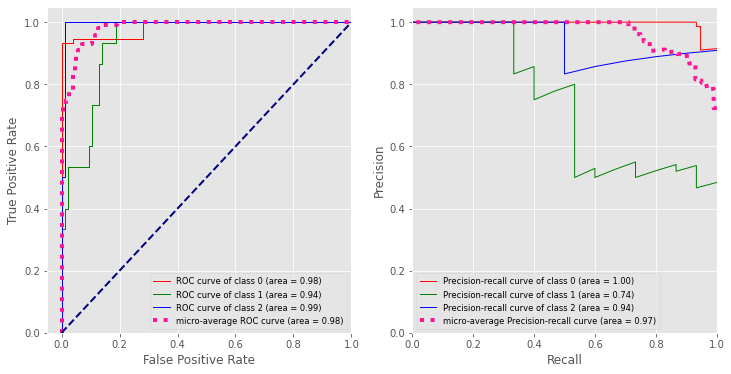

In [16]:
model = 'Neural Net MLP B'
clf_nncb = MLPClassifier(solver='adam', random_state=123)
gs_params = {'alpha': [0.001, 0.01], 'hidden_layer_sizes': [(100,), (100,100)]}
gs_score = 'roc_auc'


clf_nncb, y_pred_nncb, y_score_nncb = multiclass_classify(model, clf_nncb, features_orig, params=gs_params, score=gs_score, scale=True, OvR=False)
print('\nBest Parameters:\n',clf_nncb)

metrics_nncb, prc_nncb, roc_nncb = multiclass_metrics(model, y_test, y_pred_nncb, y_score_nncb, print_out=True, plot_out=True)